In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
def to_one_hot(df, sparse_feature):
    df[sparse_feature] = df[sparse_feature].astype(object)

    temp_col = list(set(df.columns)-set(sparse_feature))
    temp_col.sort(key=list(df.columns).index)

    df = pd.concat([df[temp_col], pd.get_dummies(df[sparse_feature])] , axis=1)

    return df

In [4]:
sample_path = './data/sample_50k'

x_train = pd.read_csv(os.path.join(sample_path, 'Normal', 'x_train.csv'), encoding='utf-8')
x_test = pd.read_csv(os.path.join(sample_path, 'Normal', 'x_test.csv'), encoding='utf-8')
y_train = pd.read_csv(os.path.join(sample_path, 'Normal', 'y_train.csv'), encoding='utf-8').values
y_test = pd.read_csv(os.path.join(sample_path, 'Normal', 'y_test.csv'), encoding='utf-8').values

chid_mapper = np.load(os.path.join(sample_path, 'sample_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'Normal', 'feature_map.npy'), allow_pickle=True).item()
feature = np.load(os.path.join(sample_path, 'Normal', 'feature.npy'), allow_pickle=True).item()

category_cols = feature['category_columns']
numeric_cols = feature['numeric_columns']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(chid_mapper), [(k, len(v)) for k, v in feat_mapper.items()])

(450000, 31) (100000, 31) (450000, 1) (100000, 1) 50000 [('masts', 4), ('educd', 7), ('naty', 3), ('trdtp', 28), ('poscd', 10), ('cuorg', 31)]


In [5]:
sparse_feat = category_cols
dense_feat = numeric_cols

In [6]:
USE_CHID = False
idx_start = 1-int(USE_CHID)

x_train_oh = to_one_hot(x_train, sparse_feat[idx_start:])
x_test_oh = to_one_hot(x_test, sparse_feat[idx_start:])

In [7]:
# x_data
x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_oh[dense_feat] = np.log1p(x_train_oh[dense_feat] - x_train_oh[dense_feat].min(axis=0))
x_train_oh[dense_feat] = x_scaler.fit_transform(x_train_oh[dense_feat])

x_test_oh[dense_feat] = np.log1p(x_test_oh[dense_feat] - x_test_oh[dense_feat].min(axis=0))
x_test_oh[dense_feat] = x_scaler.transform(x_test_oh[dense_feat])

x_train_oh = x_train_oh.values[:, idx_start:]
x_test_oh = x_test_oh.values[:, idx_start:]

In [8]:
# y_data
USE_YMINMAX = False
y_scaler = None

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

if USE_YMINMAX:
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

In [9]:
print(x_train_oh.shape, y_train.shape)
print(x_test_oh.shape, y_test.shape)

(450000, 102) (450000, 1)
(100000, 102) (100000, 1)


In [10]:
TRAIN_TYPE = [('L1loss', 'epsilon_insensitive'), 
              ('L2loss', 'squared_epsilon_insensitive')]
loss_type, loss = TRAIN_TYPE[0]

t0 = time()
svr = LinearSVR(random_state=4036, loss=loss)
svr.fit(x_train_oh, y_train.ravel())
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

cost: 92.51


In [11]:
train_true_list = y_train.ravel()
train_pred_list = svr.predict(x_train_oh)

if y_scaler:
    train_true_list = y_scaler.inverse_transform(train_true_list)
    train_pred_list = y_scaler.inverse_transform(train_pred_list)
    
train_true_list = np.expm1(train_true_list)
train_pred_list = np.expm1(train_pred_list)

train_result = {
    'RMSE': mean_squared_error(train_true_list, train_pred_list, squared=False), 
    'MAE(mean)': mean_absolute_error(train_true_list, train_pred_list), 
    'MAE(median)': median_absolute_error(train_true_list, train_pred_list)
}

In [12]:
test_true_list = y_test.ravel()
test_pred_list = svr.predict(x_test_oh)

if y_scaler:
    test_true_list = y_scaler.inverse_transform(test_true_list)
    test_pred_list = y_scaler.inverse_transform(test_pred_list)
    
test_true_list = np.expm1(test_true_list)
test_pred_list = np.expm1(test_pred_list)

test_result = {
    'RMSE': mean_squared_error(test_true_list, test_pred_list, squared=False), 
    'MAE(mean)': mean_absolute_error(test_true_list, test_pred_list), 
    'MAE(median)': median_absolute_error(test_true_list, test_pred_list)
}

In [13]:
print('train\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
print('test\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

train	RMSE:386325.12 MAE(mean):57227.39 MAE(median):11868.33
test	RMSE:404296.29 MAE(mean):61130.02 MAE(median):11380.03


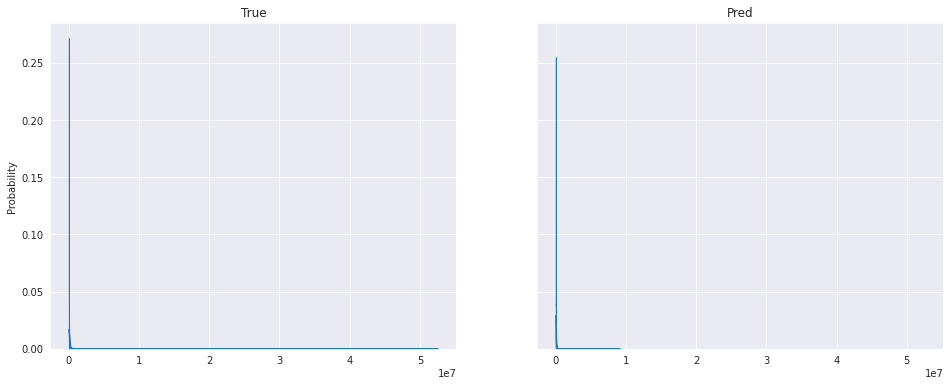

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)
    fig.suptitle('')
    
    sns.histplot(ax=axes[0], x=test_true_list, kde=True, element='step', stat='probability')
    sns.histplot(ax=axes[1], x=test_pred_list, kde=True, element='step', stat='probability')
    axes[0].set_title('True')
    axes[1].set_title('Pred')
    plt.show()

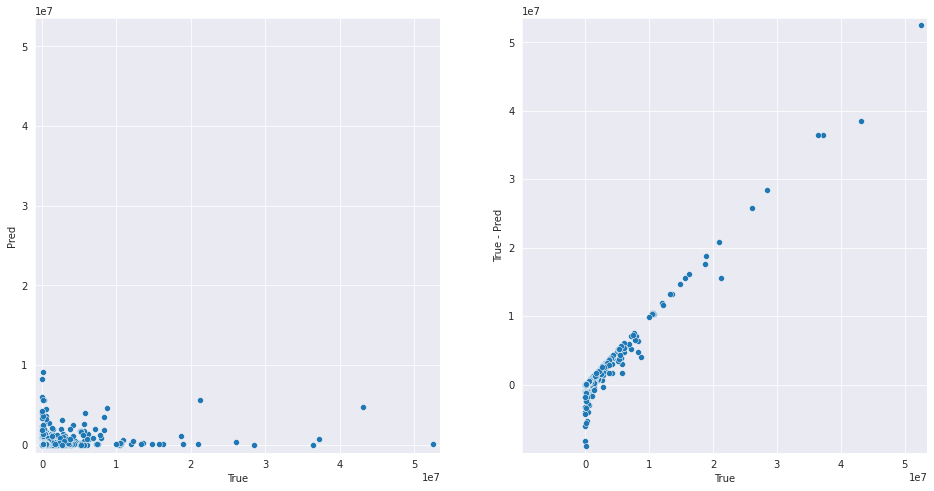

In [15]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
    fig.suptitle('')

    sns.scatterplot(ax=axes[0], x=test_true_list, y=test_pred_list)
    xylim = (np.min([test_true_list, test_pred_list])-.1e7, np.max([test_true_list, test_pred_list])+.1e7)
    axes[0].set(xlabel='True', ylabel='Pred', xlim=xylim, ylim=xylim)
    
    sns.scatterplot(ax=axes[1], x=test_true_list, y=test_true_list-test_pred_list)
    xylim = (np.min([test_true_list, test_true_list-test_pred_list])-.1e7, np.max([test_true_list, test_true_list-test_pred_list])+.1e7)
    axes[1].set(xlabel='True', ylabel='True - Pred', xlim=xylim, ylim=xylim)
    plt.show()

In [16]:
df_out = pd.DataFrame({
    'chid': x_test.iloc[:, 0].values.astype(np.int64), 
    'true': test_true_list.flatten(),
    'pred': test_pred_list.flatten()
})

df_out.head(2)

,chid,true,pred
0,0,41008.0,20618.687418
1,0,407784.0,35736.097042


In [17]:
#df_out.to_csv('result/linearSVR.csv', index=False, encoding='utf-8')